## Differential Privacy

### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In [6]:
adult = pd.read_csv("adult_with_pii.csv")
adult.head()

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56,2174,0
1,Brandise Tripony,6/7/1988,150-19-2766,61523,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,35,0,0
2,Brenn McNeely,8/6/1991,725-59-9860,95668,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,32,0,0
3,Dorry Poter,4/6/2009,659-57-4974,25503,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,14,0,0
4,Dick Honnan,9/16/1951,220-93-3811,75387,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,72,0,0


### Laplace mechanism

DP is used to answer queries. Suppose we want to know "How many individuals in the dataset are 40 years or older?"

In [18]:
adult[adult['Age']>=40].shape[0]

17450

Applying the Laplace Mechanism 

In [15]:
sensitivity = 1
epsilon = 0.1
adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=(sensitivity/epsilon))

17456.93815164522

The effect changes each time the code is run.

How much noise is enough? Suppose we want to query the following: 'Determine whether Dick Honnan has an income greater than $50k.'

In [21]:
dicks_row = adult[adult['Name'] == 'Dick Honnan']
dicks_row[dicks_row['Target'] == '<=50K'].shape[0]

1

The above result violates the privacy! Let's apply Laplace to the query

In [37]:
sensitivity = 1
epsilon = 0.1
dicks_row = adult[adult['Name'] == 'Dick Honnan']
dicks_row[dicks_row['Target'] == '<=50K'].shape[0] + np.random.laplace(loc=0, scale=(sensitivity/epsilon))

0.3881324836487333

Now there is too much noise to be able to tell this query is true or false.

### Sequential Composition

In [41]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

# satisfies 1-differential privacy
def M1():
    return np.random.laplace(loc=0, scale=1/epsilon1)

# satisfies 1-differential privacy
def M2():
    return np.random.laplace(loc=0, scale=1/epsilon2)

# satisfies 2-differential privacy
def M3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)

# satisfies 2-differential privacy, by sequential composition
def M_combined():
    return (M1() + M2()) / 2

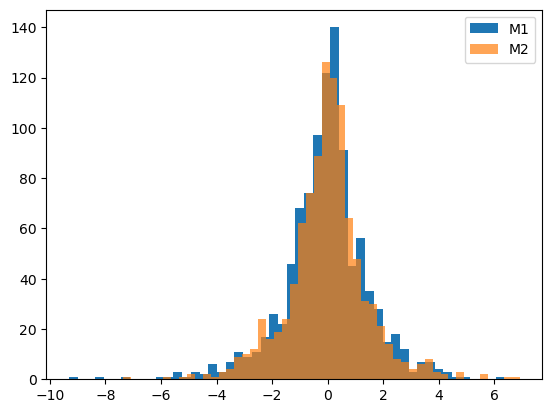

In [45]:
# plot M1
plt.hist([M1() for i in range(1000)], bins=50, label='M1');

# plot M2 (should look the same)
plt.hist([M2() for i in range(1000)], bins=50, alpha=.7, label='M2');
plt.legend();

Pretty similar results

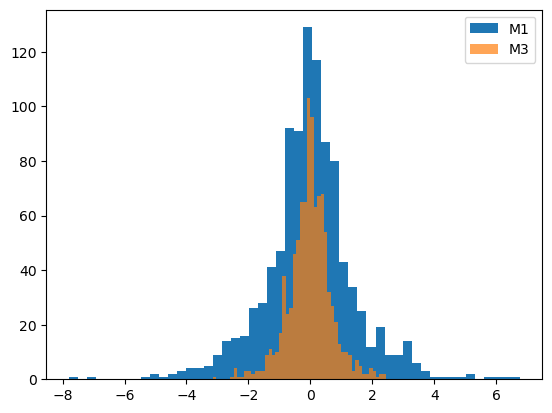

In [48]:
# plot M1
plt.hist([M1() for i in range(1000)], bins=50, label='M1')

# plot M3
plt.hist([M3() for i in range(1000)], bins=50, alpha=.7, label='M3');
plt.legend();

Somewhat more pointy shape

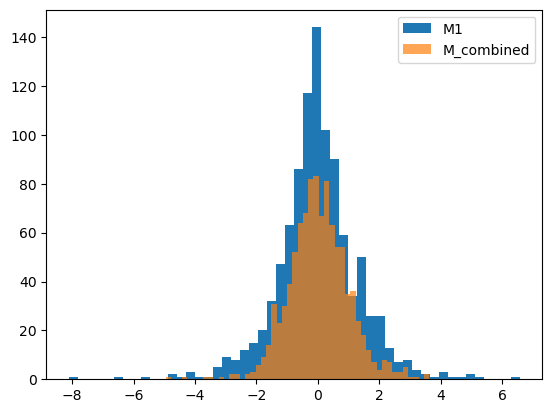

In [51]:
# plot M1
plt.hist([M1() for i in range(1000)], bins=50, label='M1');

# plot M_combined
plt.hist([M_combined() for i in range(1000)], bins=50, alpha=.7, label='M_combined');
plt.legend();

Somewhat more pointy shape

### Parellel Composition

In [58]:
adult = pd.read_csv("adult_with_pii.csv")
adult['Education'].value_counts().to_frame().head(5)

,count
Education,
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1383


Splitting in bins satisfies parallel composition, because a single row can only have one value (disjoint). We can use DP to release all of the counts with a total privacy cost $\epsilon$.

In [62]:
epsilon = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,count
Education,
HS-grad,10499.485490
Some-college,7291.261299
Bachelors,5353.900803
Masters,1723.089465
Assoc-voc,1384.060557


### Sensitivity

Counting queries always have a sensitivity of 1. This is because adding a row to the dataset can increase the output by at most 1. 

Q1: "How many people are in the dataset?"

In [66]:
adult.shape[0]

32563

Q2: "How many people have an educational status equal to or below 10?"

In [69]:
adult[adult['Education-Num'] <= 10].shape[0]

22046

Q3: "What is the sum of the ages of people with an educational status above 10?"

In [73]:
adult[adult['Education-Num'] > 10]['Age'].sum()

441431

Deciding the sensitivity of this kind of query is difficult. Adding a new row will increase the result of our example by the age of the new person. This is an unbounded sensitivity, no lower and upper bounds exist on the value.

Q4: "What is the average age of people with an educational status above 10?"

In [77]:
adult[adult['Education-Num'] > 10]['Age'].mean()

41.973091185699346

The above query can be rephrased into a summation query divided by a counting query. 

In [80]:
adult[adult['Education-Num'] > 10]['Age'].sum() / adult[adult['Education-Num'] > 10]['Age'].shape[0]

41.973091185699346

### Approximate DP

Example of the Empirical probability density function of the Gaussian versus Laplace mechanism with $\epsilon=1; \delta=10^{-5}$

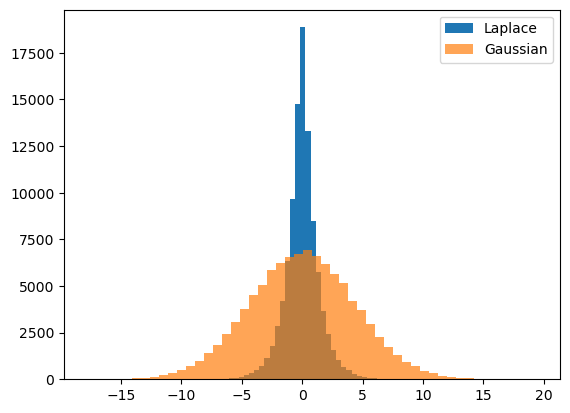

In [86]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]

plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='Gaussian');
plt.legend();

The Gaussian looks more flat and wide. It follows the Bell curve shape

### Exponential mechanism

In [97]:
options = adult['Marital Status'].unique()

def score(data, option):
    return data.value_counts()[option]/1000

score(adult['Marital Status'], 'Never-married')

10.684

In [101]:
def exponential(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]
    
    # Calculate the probability for each element, based on its score
    probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
    
    # Normalize the probabilties so they sum to 1
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)

    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

exponential(adult['Marital Status'], options, score, 1, 1)

'Married-civ-spouse'

In [103]:
r = [exponential(adult['Marital Status'], options, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

Married-civ-spouse    183
Never-married          16
Widowed                 1
Name: count, dtype: int64

### Above Threshold

In [106]:
import random

# preserves epsilon-differential privacy
def above_threshold(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)   
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
    # if the algorithm "fails", return a random index 
    # more convenient in certain use cases    
    return random.randint(0,len(queries)-1)

def above_threshold_fail_signal(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)   
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
    # return an invalid index as the special "fail" signal
    # this is convenient for implementing the sparse algorithm
    return None 
                                  

In [108]:
# preserves |queries|*epsilon-differential privacy
def naive_above_threshold(queries, df, T, epsilon):
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 1/epsilon)
        if q(df) + nu_i >= T:
            return idx
    return None

In [110]:
def age_sum_query(df, b):
    return df['Age'].clip(lower=0, upper=b).sum()

age_sum_query(adult, 30)

879648

In [114]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
    
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def naive_select_b(query, df, epsilon):
    bs = range(1, 1000, 10)
    best = 0
    threshold = 10
    epsilon_i = epsilon / len(bs)
    
    for b in bs:
        r = laplace_mech(query(df, b), b, epsilon_i)
        
        # if the new answer is pretty close to the old answer, stop
        if r - best <= threshold:
            return b
        # otherwise update the "best" answer to be the current one
        else:
            best = r
        
    return bs[-1]

naive_select_b(age_sum_query, adult, 1)

91

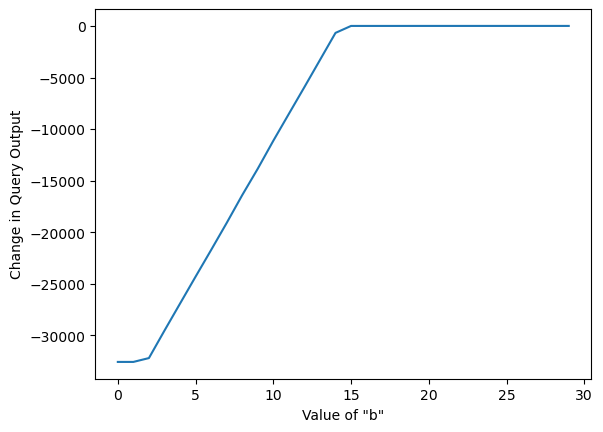

In [116]:
bs = range(1,150,5)
query_results = [age_sum_query(adult, b) - age_sum_query(adult, b + 1) for b in bs]
plt.xlabel('Value of "b"')
plt.ylabel('Change in Query Output')
plt.plot(query_results);

In [122]:
def create_query(b):
    return lambda df: age_sum_query(df, b) - age_sum_query(df, b + 1)

bs = range(1,150,5)
queries = [create_query(b) for b in bs]
epsilon = .1

bs[above_threshold(queries, adult, 0, epsilon)]

81

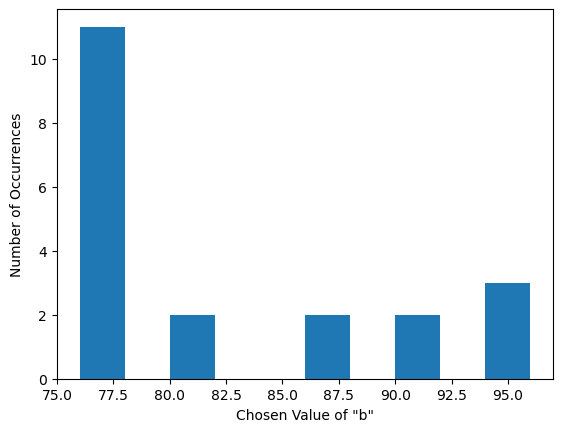

In [126]:
plt.xlabel('Chosen Value of "b"')
plt.ylabel('Number of Occurrences')
plt.hist([bs[above_threshold(queries, adult, 0, epsilon)] for i in range(20)]);